<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/debruitage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

petite illustration de comment on peut apprendre à "débruiter" des signaux

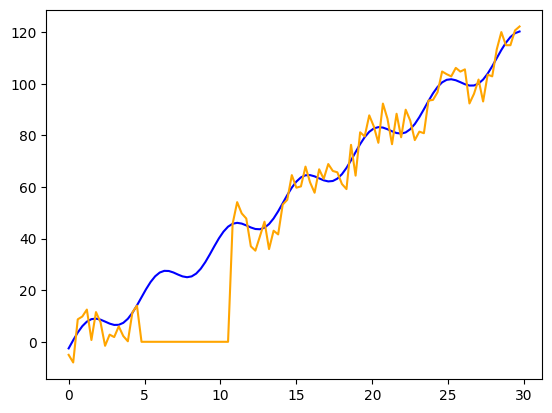

In [1]:
import torch

def generateTraj():
  x = torch.arange(100).float()*0.3
  param = (torch.rand(4)*3+1)*torch.sign(torch.rand(4)-0.5)
  signal = param[0]*x+param[1]+5*torch.cos(param[2]*x+param[3])

  signalbruitee = signal.clone()
  #bruit blanc
  signalbruitee += torch.rand(100)*20-10

  #suppression
  i = int(torch.rand(1)*50+25)
  signalbruitee[i-10:i+10]=0
  return x,signalbruitee,signal

import matplotlib.pyplot as plt
x,yn,y = generateTraj()
plt.plot(x, y, color='blue')
plt.plot(x, yn, color='orange')
plt.show()


In [2]:
class Bloc(torch.nn.Module):
  def __init__(self,Din,Dout):
    super(Bloc,self).__init__()
    self.conv1 = torch.nn.Conv1d(Din,Dout,kernel_size=11,padding=5,padding_mode="replicate",bias=False)
    self.bn1 = torch.nn.BatchNorm1d(Dout)
    self.conv2 = torch.nn.Conv1d(Dout,Dout,kernel_size=1,bias=False)
    self.bn2 = torch.nn.BatchNorm1d(Dout)

  def forward(self,x):
    x = self.bn1(self.conv1(x))
    x = torch.nn.functional.relu(x)
    x = self.conv2(self.bn2(x))
    return torch.nn.functional.relu(x)

class Net(torch.nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = Bloc(2,8)
    self.conv2 = Bloc(10,16)
    self.conv3 = Bloc(18,32)
    self.final = torch.nn.Conv1d(32,1,kernel_size=1,bias=False)

  def forward(self,x):
    f = self.conv1(x)
    f = self.conv2(torch.cat([x,f],dim=1))
    x = self.conv3(torch.cat([x,f],dim=1))
    return self.final(x)[:,0,:]

on lui apprend à débruiter

In [7]:
net = Net().train()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
for i in range(200):
  losses = []
  for j in range(50):
    X,Y = torch.zeros(8,2,100), torch.zeros(8,100)
    for k in range(8):
      X[k][0],X[k][1],Y[k] = generateTraj()

    loss = ((net(X)-Y)**2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(float(loss))
  print(i, sum(losses)/len(losses))

0 1161.8475637817382
1 243.72339195251465
2 245.64737846374513
3 215.87486831665038
4 209.26337379455566
5 110.70607521057129
6 99.74610176086426
7 101.00123664855957
8 74.51487586975098
9 73.22817680358887
10 58.22423007965088
11 57.70010864257812
12 58.741569633483884
13 62.06108734130859
14 57.06869743347168
15 58.09035110473633
16 51.502158622741696
17 47.84265689849853
18 64.35072422027588
19 57.47255645751953
20 59.03849143981934
21 51.93231937408447
22 47.51874794006348
23 33.16354465484619
24 53.02517837524414
25 52.42630989074707
26 36.59046962738037
27 41.34446716308594
28 39.81915489196777
29 39.30743949890137
30 41.456230583190916
31 42.27222324371338
32 33.9239347076416
33 35.19576374053955
34 30.910666465759277
35 31.712997055053712
36 40.28623523712158
37 48.5963720703125
38 47.38484050750733
39 33.41009498596191
40 37.04811019897461
41 32.744717292785644
42 31.04122652053833
43 28.166389808654785
44 33.46595199584961
45 31.92227958679199
46 29.884165382385255
47 43.0147

on regarde si ça marche

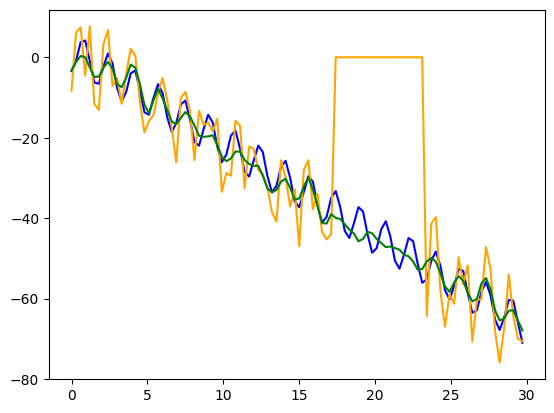

In [8]:
with torch.no_grad():
  net = net.eval()
  x,yn,y = generateTraj()
  X = torch.stack([x,yn],dim=0).view(1,2,100)
  plt.plot(x, y, color='blue')
  plt.plot(x, yn, color='orange')
  plt.plot(x, net(X)[0], color='green')
  plt.show()
